<a href="https://colab.research.google.com/github/Gibsdevops/machine-learning-with-deep-learning-/blob/main/forecasting_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [21]:
#create a function to create the time series

def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")

  if label:
    plt.legend(fontsize=14)

  plt.grid(True)

#function fot the trend
def trend(time, slope=0):
  return slope * time


#function to create the seasonal pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

#cfunction for the seasonality
def seasonality(time, period, amplitude=1, phase=0):
  #repetition
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

#add noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


#create a batch of windows
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


#prediction
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

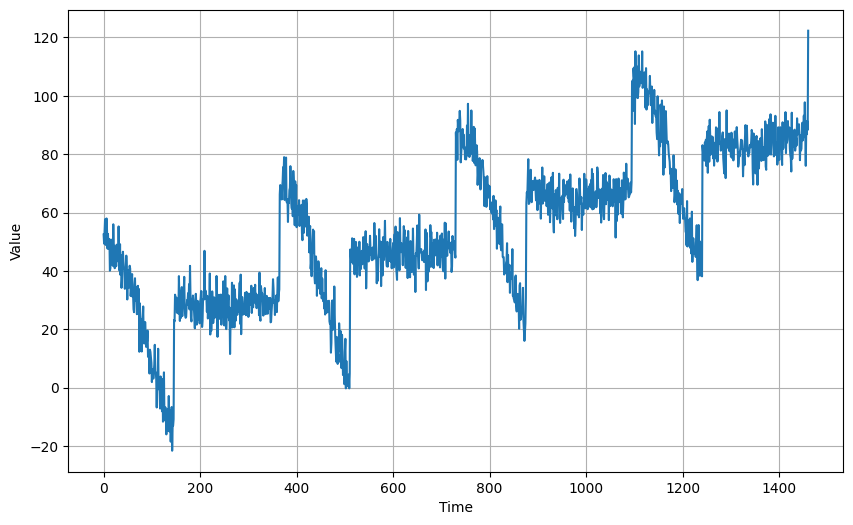

In [7]:
#create the time series

time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)


noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [9]:
#split the time series

#training set
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

#validation
time_valid = time[split_time:]
x_valid = series[split_time:]

Sequence to vector RNN

In [11]:
#Simple RNN Forecasting

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

#put the time series in tensor form
train_set = window_dataset(x_train, window_size, batch_size=128)

#create the model

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)

])

#control the learning rate with callback
lr_schedule = keras.callbacks.LearningRateScheduler(
   lambda epoch: 1e-7 * 10 ** (epoch / 20)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

#train the model
history = model.fit(
    train_set,
    epochs=100,
    callbacks = [lr_schedule]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 249.6268 - mae: 250.1268 - learning_rate: 1.0000e-07
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 209.6882 - mae: 210.1882

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 186.4501 - mae: 186.9501 - learning_rate: 1.1220e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 77.2168 - mae: 77.7159 - learning_rate: 1.2589e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 53.3925 - mae: 53.8923 - learning_rate: 1.4125e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 34.1819 - mae: 34.6796 - learning_rate: 1.5849e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 32.1452 - mae: 32.6422 - learning_rate: 1.7783e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 30.2382 - mae: 30.7316 - learning_rate: 1.9953e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 27.5350 - mae: 28.0253 - learning_rate: 2.2387e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 24.8758 - mae: 25.3677 - learning_rate: 2.5119e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 23.3291 - mae: 23.8212 - learning_rate: 2.8184e-07
Epoch 11/100
8/8 ━━━━━━━━━━━

(np.float64(1e-07), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

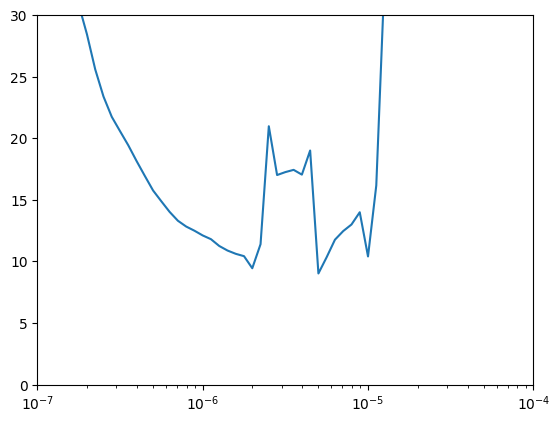

In [12]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


#using the best learning _rate and implemening early stoping
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      7/Unknown 3s 56ms/step - loss: 56.6330 - mae: 57.1313

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 55.1208 - mae: 55.6190 - val_loss: 55.6241 - val_mae: 56.1241
Epoch 2/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 36.1231 - mae: 36.6186

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 35.6479 - mae: 36.1435 - val_loss: 11.3861 - val_mae: 11.8787
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 18.1744 - mae: 18.6719 - val_loss: 13.7982 - val_mae: 14.2953
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 13.7218 - mae: 14.2088 - val_loss: 15.0333 - val_mae: 15.5271
Epoch 5/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 12.2692 - mae: 12.7558

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 12.0661 - mae: 12.5522 - val_loss: 11.3371 - val_mae: 11.8314
Epoch 6/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 10.2723 - mae: 10.7622

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 10.2791 - mae: 10.7681 - val_loss: 7.0205 - val_mae: 7.5066
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 10.2499 - mae: 10.7356 - val_loss: 9.0376 - val_mae: 9.5282
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.5471 - mae: 10.0295 - val_loss: 9.4758 - val_mae: 9.9699
Epoch 9/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.9174 - mae: 9.4003

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.8280 - mae: 9.3107 - val_loss: 6.0834 - val_mae: 6.5610
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.5641 - mae: 9.0437 - val_loss: 7.6888 - val_mae: 8.1692
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.6294 - mae: 8.1088 - val_loss: 6.8388 - val_mae: 7.3205
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.5236 - mae: 8.0053 - val_loss: 7.7918 - val_mae: 8.2740
Epoch 13/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.5224 - mae: 8.0012

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.5077 - mae: 7.9873 - val_loss: 5.8691 - val_mae: 6.3489
Epoch 14/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.2980 - mae: 7.7737 - val_loss: 6.9526 - val_mae: 7.4395
Epoch 15/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.3169 - mae: 7.7959

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 7.2438 - mae: 7.7232 - val_loss: 5.6625 - val_mae: 6.1410
Epoch 16/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 6.7768 - mae: 7.2534 - val_loss: 5.8966 - val_mae: 6.3808
Epoch 17/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 6.9684 - mae: 7.4522 - val_loss: 6.0354 - val_mae: 6.5188
Epoch 18/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 6.3717 - mae: 6.8540 - val_loss: 6.0675 - val_mae: 6.5498
Epoch 19/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.3944 - mae: 6.8746 - val_loss: 6.1064 - val_mae: 6.5892
Epoch 20/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6.1588 - mae: 6.6348 - val_loss: 5.7347 - val_mae: 6.2177
Epoch 21/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.3677 - mae: 6.8406 - val_loss: 5.8255 - val_mae: 6.3084
Epoch 22/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.8450 - mae: 7.3223

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 6.7401 - mae: 7.2177 - val_loss: 5.3283 - val_mae: 5.8144
Epoch 23/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 6.5806 - mae: 7.0580 - val_loss: 6.4857 - val_mae: 6.9664
Epoch 24/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 6.3001 - mae: 6.7792 - val_loss: 5.8195 - val_mae: 6.3035
Epoch 25/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.0292 - mae: 6.5059

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 6.0253 - mae: 6.5028 - val_loss: 5.2764 - val_mae: 5.7600
Epoch 26/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.9558 - mae: 6.4344 - val_loss: 6.5158 - val_mae: 6.9981
Epoch 27/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.2556 - mae: 6.7327 - val_loss: 5.5296 - val_mae: 6.0081
Epoch 28/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.7280 - mae: 6.2122

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 5.8271 - mae: 6.3110 - val_loss: 5.2434 - val_mae: 5.7240
Epoch 29/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 6.4700 - mae: 6.9498 - val_loss: 6.9684 - val_mae: 7.4495
Epoch 30/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.1938 - mae: 6.6711 - val_loss: 5.2578 - val_mae: 5.7383
Epoch 31/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.9312 - mae: 6.4089 - val_loss: 6.7078 - val_mae: 7.1883
Epoch 32/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - loss: 5.8581 - mae: 6.3357 - val_loss: 5.2971 - val_mae: 5.7725
Epoch 33/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.5604 - mae: 6.0374 - val_loss: 5.6849 - val_mae: 6.1648
Epoch 34/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.6755 - mae: 6.1525 - val_loss: 7.5738 - val_mae: 8.0587
Epoch 35/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.4921 - mae: 6.9751

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.3510 - mae: 6.8335 - val_loss: 5.2368 - val_mae: 5.7197
Epoch 36/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.5084 - mae: 6.9886 - val_loss: 5.6855 - val_mae: 6.1642
Epoch 37/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.6795 - mae: 6.1521 - val_loss: 5.7514 - val_mae: 6.2332
Epoch 38/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.5124 - mae: 5.9928

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.5627 - mae: 6.0433 - val_loss: 5.1965 - val_mae: 5.6793
Epoch 39/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.4874 - mae: 5.9608 - val_loss: 5.6058 - val_mae: 6.0841
Epoch 40/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.8245 - mae: 6.3049 - val_loss: 6.7778 - val_mae: 7.2576
Epoch 41/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.9514 - mae: 6.4270

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.9219 - mae: 6.3983 - val_loss: 5.1848 - val_mae: 5.6646
Epoch 42/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 5.4324 - mae: 5.9095 - val_loss: 5.7086 - val_mae: 6.1917
Epoch 43/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.1706 - mae: 5.6496 - val_loss: 6.0192 - val_mae: 6.5030
Epoch 44/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.6106 - mae: 6.0858

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.6109 - mae: 6.0863 - val_loss: 5.0976 - val_mae: 5.5831
Epoch 45/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 5.7718 - mae: 6.2541 - val_loss: 6.0416 - val_mae: 6.5266
Epoch 46/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.4785 - mae: 5.9565 - val_loss: 5.2233 - val_mae: 5.7011
Epoch 47/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.4289 - mae: 5.9045 - val_loss: 5.1690 - val_mae: 5.6481
Epoch 48/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.3311 - mae: 5.8047 - val_loss: 7.4871 - val_mae: 7.9731
Epoch 49/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 5.9202 - mae: 6.4034 - val_loss: 5.5789 - val_mae: 6.0606
Epoch 50/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 5.1236 - mae: 5.5994 - val_loss: 5.7770 - val_mae: 6.2631
Epoch 51/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.1418 - mae: 5.6090

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.2284 - mae: 5.6969 - val_loss: 5.0649 - val_mae: 5.5442
Epoch 52/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.8366 - mae: 6.3195 - val_loss: 5.3429 - val_mae: 5.8196
Epoch 53/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.5524 - mae: 6.0268 - val_loss: 5.7738 - val_mae: 6.2582
Epoch 54/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.1683 - mae: 5.6475 - val_loss: 5.6335 - val_mae: 6.1165
Epoch 55/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.2635 - mae: 5.7425 - val_loss: 5.2740 - val_mae: 5.7540
Epoch 56/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.6990 - mae: 6.1750 - val_loss: 5.4239 - val_mae: 5.8990
Epoch 57/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.0658 - mae: 5.5430 - val_loss: 5.5399 - val_mae: 6.0206
Epoch 58/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.1894 - mae: 5.6613

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1946 - mae: 5.6667 - val_loss: 4.9832 - val_mae: 5.4612
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.4163 - mae: 5.8995 - val_loss: 6.1294 - val_mae: 6.6129
Epoch 60/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.3836 - mae: 5.8539 - val_loss: 5.5441 - val_mae: 6.0261
Epoch 61/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.2503 - mae: 5.7181 - val_loss: 4.9940 - val_mae: 5.4717
Epoch 62/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.3696 - mae: 5.8525 - val_loss: 5.4293 - val_mae: 5.9055
Epoch 63/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.4037 - mae: 5.8793 - val_loss: 5.1435 - val_mae: 5.6224
Epoch 64/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.4668 - mae: 5.9434 - val_loss: 5.1121 - val_mae: 5.5900
Epoch 65/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.2657 - mae: 5.7465 - val_loss: 5.6199 - val_mae: 6.1039
Epoch 66/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 4.9519 - mae: 5.42

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.2554 - mae: 5.7337 - val_loss: 4.9647 - val_mae: 5.4425
Epoch 68/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.8476 - mae: 5.3252 - val_loss: 5.0274 - val_mae: 5.5068
Epoch 69/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 5.0535 - mae: 5.5267 - val_loss: 5.1279 - val_mae: 5.6043
Epoch 70/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.8810 - mae: 5.3557 - val_loss: 4.9923 - val_mae: 5.4698
Epoch 71/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.6011 - mae: 6.0808 - val_loss: 7.7751 - val_mae: 8.2656
Epoch 72/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.1273 - mae: 6.6094 - val_loss: 5.5876 - val_mae: 6.0718
Epoch 73/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.9998 - mae: 6.4800 - val_loss: 7.0657 - val_mae: 7.5471
Epoch 74/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.3018 - mae: 5.7761 - val_loss: 5.3324 - val_mae: 5.8070
Epoch 75/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.9028 - mae: 5.38

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 4.8082 - mae: 5.2841 - val_loss: 4.9388 - val_mae: 5.4182
Epoch 85/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.8549 - mae: 5.3312 - val_loss: 5.3391 - val_mae: 5.8135
Epoch 86/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.8103 - mae: 5.2864

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.8149 - mae: 5.2913 - val_loss: 4.9254 - val_mae: 5.4060
Epoch 87/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.1875 - mae: 5.6635 - val_loss: 4.9277 - val_mae: 5.4077
Epoch 88/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.6702 - mae: 5.1429 - val_loss: 4.9604 - val_mae: 5.4401
Epoch 89/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.9979 - mae: 5.4699 - val_loss: 5.3655 - val_mae: 5.8414
Epoch 90/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.9453 - mae: 5.4226 - val_loss: 5.3366 - val_mae: 5.8123
Epoch 91/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.1065 - mae: 5.5775 - val_loss: 5.2246 - val_mae: 5.7020
Epoch 92/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.2749 - mae: 5.7513 - val_loss: 6.7099 - val_mae: 7.1946
Epoch 93/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.9981 - mae: 5.4737

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.9656 - mae: 5.4416 - val_loss: 4.9044 - val_mae: 5.3884
Epoch 94/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.8107 - mae: 5.2879 - val_loss: 5.2553 - val_mae: 5.7300
Epoch 95/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.0650 - mae: 5.5485 - val_loss: 7.7656 - val_mae: 8.2570
Epoch 96/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 6.0642 - mae: 6.5490 - val_loss: 4.9403 - val_mae: 5.4198
Epoch 97/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.9254 - mae: 5.3992 - val_loss: 5.4920 - val_mae: 5.9707
Epoch 98/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.1034 - mae: 5.5815 - val_loss: 5.0233 - val_mae: 5.5029
Epoch 99/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 5.2402 - mae: 5.7187 - val_loss: 5.9329 - val_mae: 6.4166
Epoch 100/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8878 - mae: 5.3648 - val_loss: 4.9732 - val_mae: 5.4587
Epoch 101/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.9842 - mae: 5

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.9097 - mae: 5.3800 - val_loss: 4.8714 - val_mae: 5.3539
Epoch 108/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.7679 - mae: 5.2462 - val_loss: 5.4078 - val_mae: 5.8835
Epoch 109/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.6473 - mae: 5.1215

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.6368 - mae: 5.1111 - val_loss: 4.8368 - val_mae: 5.3156
Epoch 110/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 4.4500 - mae: 4.9302 - val_loss: 5.8251 - val_mae: 6.3073
Epoch 111/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.3925 - mae: 4.8690 - val_loss: 4.8418 - val_mae: 5.3271
Epoch 112/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.5776 - mae: 5.0518

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.6125 - mae: 5.0869 - val_loss: 4.8245 - val_mae: 5.3065
Epoch 113/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.8537 - mae: 5.3285 - val_loss: 5.7619 - val_mae: 6.2459
Epoch 114/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.9370 - mae: 5.4122 - val_loss: 5.4595 - val_mae: 5.9435
Epoch 115/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.2222 - mae: 5.6971 - val_loss: 7.8130 - val_mae: 8.3071
Epoch 116/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.2833 - mae: 5.7626 - val_loss: 4.9303 - val_mae: 5.4175
Epoch 117/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.7362 - mae: 5.2103 - val_loss: 5.0935 - val_mae: 5.5698
Epoch 118/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.3633 - mae: 4.8414 - val_loss: 4.8947 - val_mae: 5.3720
Epoch 119/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.5100 - mae: 4.9865 - val_loss: 5.0881 - val_mae: 5.5643
Epoch 120/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 5.0586 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.4795 - mae: 4.9563 - val_loss: 4.8214 - val_mae: 5.3025
Epoch 134/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.4858 - mae: 4.9593 - val_loss: 5.1417 - val_mae: 5.6164
Epoch 135/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.3332 - mae: 4.8033 - val_loss: 4.8735 - val_mae: 5.3622
Epoch 136/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.6623 - mae: 5.1343 - val_loss: 5.9143 - val_mae: 6.3946
Epoch 137/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.4609 - mae: 4.9291 - val_loss: 5.0929 - val_mae: 5.5673
Epoch 138/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.7288 - mae: 5.2048 - val_loss: 5.7887 - val_mae: 6.2688
Epoch 139/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 4.6092 - mae: 5.0838 - val_loss: 4.8472 - val_mae: 5.3278
Epoch 140/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 4.8181 - mae: 5.2908 - val_loss: 4.8692 - val_mae: 5.3459
Epoch 141/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 4.9641 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.1604 - mae: 4.6331 - val_loss: 4.8188 - val_mae: 5.3028
Epoch 147/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.2721 - mae: 4.7490 - val_loss: 5.0903 - val_mae: 5.5643
Epoch 148/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.3372 - mae: 4.8083 - val_loss: 5.2918 - val_mae: 5.7695
Epoch 149/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.0827 - mae: 4.5521 - val_loss: 4.9028 - val_mae: 5.3803
Epoch 150/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.3882 - mae: 4.8560 - val_loss: 5.1673 - val_mae: 5.6425
Epoch 151/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.4483 - mae: 4.9179 - val_loss: 4.9055 - val_mae: 5.3845
Epoch 152/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.4822 - mae: 4.9568 - val_loss: 5.7901 - val_mae: 6.2716
Epoch 153/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.6522 - mae: 5.1241

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.6842 - mae: 5.1566 - val_loss: 4.8108 - val_mae: 5.2920
Epoch 154/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.3034 - mae: 4.7738 - val_loss: 5.9450 - val_mae: 6.4260
Epoch 155/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3210 - mae: 4.7958 - val_loss: 4.8354 - val_mae: 5.3149
Epoch 156/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 4.5883 - mae: 5.0586 - val_loss: 5.4348 - val_mae: 5.9126
Epoch 157/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.7068 - mae: 5.1842 - val_loss: 5.4768 - val_mae: 5.9536
Epoch 158/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.7280 - mae: 5.2018 - val_loss: 5.0124 - val_mae: 5.4841
Epoch 159/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.0023 - mae: 5.4820 - val_loss: 6.7714 - val_mae: 7.2562
Epoch 160/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.0973 - mae: 5.5742 - val_loss: 4.8496 - val_mae: 5.3371
Epoch 161/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.2103 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.4390 - mae: 4.9151 - val_loss: 4.8025 - val_mae: 5.2849
Epoch 165/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3966 - mae: 4.8727 - val_loss: 4.9086 - val_mae: 5.3879
Epoch 166/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.2693 - mae: 4.7418

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.2780 - mae: 4.7504 - val_loss: 4.7937 - val_mae: 5.2746
Epoch 167/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.2588 - mae: 4.7271 - val_loss: 5.2521 - val_mae: 5.7298
Epoch 168/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 4.3795 - mae: 4.8552 - val_loss: 5.5551 - val_mae: 6.0338
Epoch 169/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 4.5267 - mae: 4.9996 - val_loss: 5.1911 - val_mae: 5.6696
Epoch 170/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 4.6959 - mae: 5.1726 - val_loss: 4.9643 - val_mae: 5.4386
Epoch 171/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.2047 - mae: 4.6819 - val_loss: 4.8136 - val_mae: 5.2968
Epoch 172/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.4747 - mae: 4.9517 - val_loss: 4.9376 - val_mae: 5.4142
Epoch 173/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.5443 - mae: 5.0240 - val_loss: 5.1765 - val_mae: 5.6533
Epoch 174/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.3677 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 4.4239 - mae: 4.8956 - val_loss: 4.7688 - val_mae: 5.2497
Epoch 181/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 4.3524 - mae: 4.8255 - val_loss: 4.9216 - val_mae: 5.3989
Epoch 182/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.1914 - mae: 4.6600 - val_loss: 4.8489 - val_mae: 5.3274
Epoch 183/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.3252 - mae: 4.7992 - val_loss: 5.1076 - val_mae: 5.5833
Epoch 184/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.3693 - mae: 4.8421 - val_loss: 4.7709 - val_mae: 5.2520
Epoch 185/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.2790 - mae: 4.7521 - val_loss: 4.9027 - val_mae: 5.3800
Epoch 186/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 4.1101 - mae: 4.5726 - val_loss: 5.6557 - val_mae: 6.1316
Epoch 187/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.2975 - mae: 4.7711 - val_loss: 5.1252 - val_mae: 5.6009
Epoch 188/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.1342 - 

In [40]:
# ipython-input-38-6f1f216ed032

# Clear any previous Keras state
keras.backend.clear_session()

# Define the model architecture exactly as it was during training
# This architecture must match the model that saved the weights in my_checkpoint.h5
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

# Load only the weights from the saved file into the defined model
# This assumes my_checkpoint.h5 contains only the weights
# If it contains the full model, the previous load_model should have worked
try:
    model.load_weights("my_checkpoint.h5")
    print("Successfully loaded model weights.")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Please ensure 'my_checkpoint.h5' exists and contains valid weights.")


# Compile the model after loading weights if you plan to continue training
# or if the model was compiled during saving and you need the optimizer state etc.
# If you only need to make predictions, compiling might not be strictly necessary
# depending on your exact use case, but it's good practice if the model was
# originally compiled.
# For consistency, we can compile it with the same settings as the best model
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9) # Use the learned best learning rate
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Now the 'model' variable holds the defined architecture with the loaded weights.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Successfully loaded model weights.


In [41]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


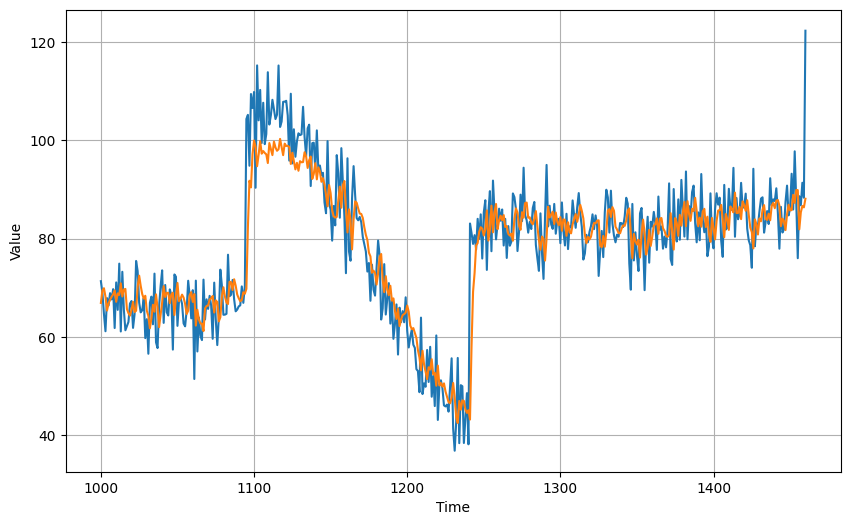

In [42]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [44]:
# Create an instance of the MeanAbsoluteError metric
mae_metric = keras.metrics.MeanAbsoluteError()

# Update the metric with the true values (x_valid) and the predicted values (rnn_forecast)
mae_metric.update_state(x_valid, rnn_forecast)

# Get the final result (the mean absolute error) and convert it to a NumPy value
mean_absolute_error_value = mae_metric.result().numpy()

# Print or use the calculated MAE
print(f"Mean Absolute Error: {mean_absolute_error_value}")

# The line below was the original line causing the error and should be removed
# keras.metrics.MeanAbsoluteError(x_valid, rnn_forecast).numpy()

Mean Absolute Error: 5.175409317016602


sequence to sequence forecasting


In [46]:
#function for the dataset

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 290.9036 - mae: 291.4036 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 252.8203 - mae: 253.3203 - learning_rate: 1.0798e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 184.9915 - mae: 185.4915 - learning_rate: 1.1659e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 91.3834 - mae: 91.8829 - learning_rate: 1.2589e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 42.3943 - mae: 42.8920 - learning_rate: 1.3594e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 45.4835 - mae: 45.9824 - learning_rate: 1.4678e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 29.5990 - mae: 30.0922 - learning_rate: 1.5849e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 27.6287 - mae: 28.1227 - learning_rate: 1.7113e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 26.5513 - mae: 27.0454 - learning_rate: 1.8478e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 24.9104 - mae: 25.4004 - learning_rate: 1.9953e-07
Epoch 11/100
8/8 ━━━━━━━━

(np.float64(1e-07), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

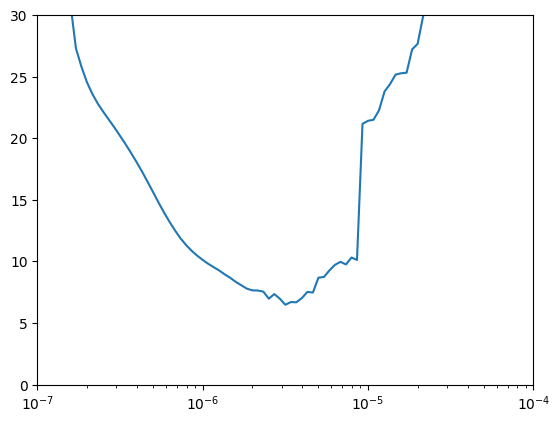

In [50]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      7/Unknown 3s 36ms/step - loss: 29.7527 - mae: 30.2470

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 29.6158 - mae: 30.1104 - val_loss: 44.5486 - val_mae: 45.0473
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 24.9883 - mae: 25.4801 - val_loss: 27.7622 - val_mae: 28.2598
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 21.9693 - mae: 22.4613 - val_loss: 19.3868 - val_mae: 19.8814
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 20.8565 - mae: 21.3463 - val_loss: 16.3622 - val_mae: 16.8551
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 18.3228 - mae: 18.8114 - val_loss: 15.9762 - val_mae: 16.4690
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 17.4210 - mae: 17.9091 - val_loss: 17.0881 - val_mae: 17.5825
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 16.0022 - mae: 16.4874 - val_loss: 16.4484 - val_mae: 16.9424
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 15.6208 - mae: 16.1062 - val_loss: 13.1806 - val_mae: 13.6735
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/st

In [53]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


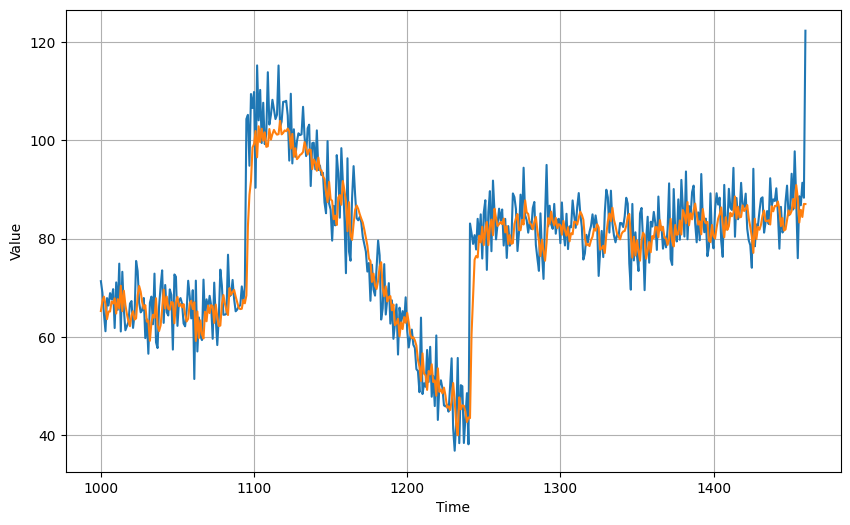

In [54]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [55]:
# Create an instance of the MeanAbsoluteError metric
mae_metric = keras.metrics.MeanAbsoluteError()

# Update the metric with the true values (x_valid) and the predicted values (rnn_forecast)
mae_metric.update_state(x_valid, rnn_forecast)

# Get the final result (the mean absolute error) and convert it to a NumPy value
mean_absolute_error_value = mae_metric.result().numpy()

# Print or use the calculated MAE
print(f"Mean Absolute Error: {mean_absolute_error_value}")

# The line below was the original line causing the error and should be removed
# keras.metrics.MeanAbsoluteError(x_valid, rnn_forecast).numpy()

Mean Absolute Error: 4.9835357666015625
